# Import Libraries

In [25]:
#!pip install pytorch_tabnet

In [163]:
import os
import warnings
warnings.simplefilter('ignore')
warnings.filterwarnings("ignore", message="Device used : cpu", category=UserWarning)

import numpy as np
import pandas as pd
import polars as pl


# visual
import pandas_profiling
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import GroupKFold 
from sklearn.metrics import mean_absolute_percentage_error as mape
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GroupShuffleSplit
from sklearn.metrics import mean_squared_error

import lightgbm as lgb
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor,Pool
import xgboost as xgb

import torch
from torch import nn
from torch.autograd import Variable
from torch.utils.data import DataLoader, Dataset, TensorDataset
import torch.optim as optim
import torch.nn.functional as F
from torch.optim.lr_scheduler import ReduceLROnPlateau

# Configuration

In [27]:
class config:
    METRIC = 'RMSE' #RMSE or SMAPE
    RANDOM_STATE=100  
    FRAC = 0.2
    N_FOLD = 5
    
class paths:
    # kaggle環境ならTrue
    if 'KAGGLE_URL_BASE' in set(os.environ.keys()):
        common_path = "/kaggle/input/amp-parkinsons-disease-progression-prediction"
    
    # colaboratory環境ならTrue
    if 'COLAB_GPU' in set(os.environ.keys()):
        common_path = "/content/drive/MyDrive/AMP"
    
    SAMPLE_SUBMISSION = common_path + "/example_test_files/sample_submission.csv"
    SUPPLEMENTAL_CLINICAL_DATA = common_path + "/supplemental_clinical_data.csv"
    TRAIN_CLINICAL_DATA = common_path + "/train_clinical_data.csv"
    TRAIN_PEPTIDES = common_path + "/train_peptides.csv"
    TRAIN_PROTEINS = common_path + "/train_proteins.csv"
    TEST_CLINICAL_DATA = common_path + "/example_test_files/test.csv"
    TEST_PEPTIDES = common_path + "/example_test_files/test_peptides.csv"
    TEST_PROTEINS = common_path + "/example_test_files/test_proteins.csv"

# Function Definition

## display_feature_importance 

In [28]:
def display_feature_importance(feature_list,model):

    # 特徴量重要度を保管する dataframe を用意
    feature_importance = pd.DataFrame()
    feature_importance['feature'] = feature_list
    feature_importance['importance'] = model.feature_importances_

    print('****************************') 
    display(feature_importance.groupby("feature")["importance"].mean().sort_values(ascending=False)[:20])

    # order = list(feature_importance.groupby("feature")["importance"].mean().sort_values(ascending=False).index)[:30]
    # # 可視化
    # plt.figure(figsize=(10, 10))
    # sns.barplot(x="importance",y="feature",data=feature_importance,order=order)
    # plt.title('importance')
    # plt.tight_layout()
    # plt.show()

## score_cal

In [29]:
def score_cal(y_true, y_pred,metric = config.METRIC):
  if metric == 'SMAPE':
    y_true = y_true + 1
    y_pred = y_pred + 1
    smap = np.zeros(len(y_true))
    num = np.abs((y_true) - (y_pred))
    dem = ((np.abs(y_true) + np.abs(y_pred)) / 2)
    pos_ind = ((y_true)!=0)|((y_pred)!=0)
    smap[pos_ind] = num[pos_ind] / dem[pos_ind]
    ret = 100 * np.mean(smap)
  if metric == 'RMSE':
    ret = np.sqrt(mean_squared_error(y_true,y_pred))

  return ret

## fit_catboost_fold1

In [30]:
def fit_catboost_fold1(X,y):

  X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=config.FRAC, random_state=config.RANDOM_STATE,shuffle=True)

  train_pool = Pool(X_train, y_train)
  model = CatBoostRegressor(random_seed=config.RANDOM_STATE,logging_level='Silent',eval_metric = config.METRIC)
  model.fit(train_pool,plot=False, verbose=False)  

  test_score = score_cal(y_val, model.predict(X_val))
  print('****************************')
  print(f"Test data average score : {test_score:.4f}"," seed ", config.RANDOM_STATE)

  return model,test_score

# Load Data

In [31]:
train_clinical = pd.read_csv(paths.TRAIN_CLINICAL_DATA)
train_peptides = pd.read_csv(paths.TRAIN_PEPTIDES)
train_proteins = pd.read_csv(paths.TRAIN_PROTEINS)
supplemental_clinical = pd.read_csv(paths.SUPPLEMENTAL_CLINICAL_DATA)
#print('Correct label:Proteins shape: (232741, 5) Peptides shape: (981834, 6) Clinical shape: (2615, 8)')
print('Proteins shape:',train_proteins.shape)
print('Peptides shape:',train_peptides.shape)
print('Clinical shape:',train_clinical.shape)
print('supplemental_clinical shape:',supplemental_clinical.shape)

test_clinical = pd.read_csv(paths.TEST_CLINICAL_DATA)
test_peptides = pd.read_csv(paths.TEST_PEPTIDES)
test_proteins = pd.read_csv(paths.TEST_PROTEINS)
sample_submission= pd.read_csv(paths.SAMPLE_SUBMISSION)
print('Proteins shape:',test_proteins.shape)
print('Peptides shape:',test_peptides.shape)
print('Clinical shape:',test_clinical.shape)


Proteins shape: (232741, 5)
Peptides shape: (981834, 6)
Clinical shape: (2615, 8)
supplemental_clinical shape: (2223, 8)
Proteins shape: (453, 6)
Peptides shape: (2057, 7)
Clinical shape: (16, 6)


# Data Cleaning

In [32]:
train_clinical.replace({'On':1,'Off':0},inplace=True)
supplemental_clinical.replace({'On':1,'Off':0},inplace=True)

#欠損値処理
train_clinical.dropna(subset=['updrs_1'],inplace=True)
train_clinical.dropna(subset=['updrs_2'],inplace=True)

#以下は要精査
train_clinical.dropna(subset=['updrs_3'],inplace=True) 
train_clinical['upd23b_clinical_state_on_medication'] = train_clinical['upd23b_clinical_state_on_medication'].fillna(0)
train_clinical['updrs_4'] = train_clinical['updrs_4'].fillna(0)

#お試し。数値情報のlog化
train_peptides['PeptideAbundance'] = train_peptides['PeptideAbundance'].apply(np.log)
#train_peptides[['PeptideAbundance']].describe()
train_proteins['NPX'] = train_proteins['NPX'].apply(np.log)
#train_proteins[['PeptideAbundance']].describe()

train_clinical.isna().sum()

# Todo updrs_4は欠損値埋めしたいものの、適切な値がない… -> エラー避けるため0埋め

visit_id                               0
patient_id                             0
visit_month                            0
updrs_1                                0
updrs_2                                0
updrs_3                                0
updrs_4                                0
upd23b_clinical_state_on_medication    0
dtype: int64

# common

In [33]:
#sort用にキー列のみ抽出
train_sort = train_clinical[['visit_id','patient_id','visit_month']]

# Feature Engineering

# Te updrs <- updrs

In [154]:
#te用にコピー作る
train_clinical_te = train_clinical.copy()
train_peptides_te = train_peptides.copy()
train_proteins_te = train_proteins.copy()
supplemental_te = supplemental_clinical.copy()

train_clisup_ = pd.concat([train_clinical_te,supplemental_te])
#train_clisup_ = train_clinical_te.copy() #supplementalを使わない場合

train_clisup = train_clisup_[['updrs_1','updrs_2','updrs_3']]
for i in range(3) :
  train_clisup_tmp = pl.DataFrame(train_clisup).groupby(['updrs_{0}'.format(i+1)]).agg(
    [
        pl.mean("*").suffix("_mean_by_"+'updrs_{0}'.format(i+1)),
        #pl.std("*").suffix("_std_by_Pep"),
        pl.median("*").suffix("_median_by_"+'updrs_{0}'.format(i+1)),
        #pl.max("*").suffix("_max_by_Pep"),
        #pl.min("*").suffix("_min_by_"+'updrs_{0}'.format(i+1)),
    ]
  ).to_pandas()
  locals()["te_updrs_{0}".format(i+1)] = train_clisup_tmp.dropna()

te_updrs_1.head()

,updrs_1,updrs_2_mean_by_updrs_1,updrs_3_mean_by_updrs_1,updrs_2_median_by_updrs_1,updrs_3_median_by_updrs_1
0,15.0,13.517241,27.770115,14.0,25.0
1,3.0,3.922680,17.530928,3.0,17.0
2,5.0,5.421546,19.676815,5.0,19.0
3,27.0,20.166667,40.333333,18.0,36.0
4,23.0,18.000000,37.363636,18.0,33.0


In [34]:
#--- clinical ---#
train_clinical
train_peptides
train_proteins

#--- peptides ---#

def encoder(df,type='pep'):
    if type == 'pep':
        key='Peptide'
        agg_value='PeptideAbundance'
    else:
        key='UniProt'
        agg_value='NPX'

    #UniProtごとの集計
    df_agg_ = pl.DataFrame(df).groupby([key],maintain_order=True).agg([
            pl.mean(agg_value).suffix("_mean_by_id"),
            pl.std(agg_value).suffix("_std_by_id"),
            pl.max(agg_value).suffix("_max_by_id"),
            pl.median(agg_value).suffix("_med_by_id"),
    ]).to_pandas()

    df_agg = df[['visit_id',key,agg_value]].merge(df_agg_,on=key)

    df_agg['Diff_' + agg_value + '_ori_mean'] = df_agg[agg_value] - df_agg[agg_value + '_mean_by_id']
    df_agg['Div_' + agg_value + '_ori_mean'] = df_agg[agg_value] / df_agg[agg_value + '_mean_by_id']
    df_agg['Div_' + agg_value + '_ori_std'] = df_agg[agg_value] / df_agg[agg_value + '_std_by_id']
    df_agg['Div_' + agg_value + '_max_std'] = df_agg[agg_value + '_max_by_id'] / df_agg[agg_value + '_std_by_id']
    df_agg['Div_' + agg_value + '_med_std'] = df_agg[agg_value + '_med_by_id'] / df_agg[agg_value + '_std_by_id']
    
    #不要行の削除
    df_agg.drop([key,agg_value + '_mean_by_id',agg_value + '_std_by_id',],axis=1,inplace=True)

    #PeptideAbundanceのagg
    df_agg_ret = pl.DataFrame(df_agg).groupby(['visit_id'],maintain_order=True).agg([
            pl.mean('*').suffix("_mean_by_id"),
            pl.std('*').suffix("_std_by_id"),
            pl.max('*').suffix("_max_by_id"),
            pl.median('*').suffix("_med_by_id"),
    ]).to_pandas()
    
    return df_agg_ret

en_peptides = encoder(train_peptides,type = 'pep')
en_proteins = encoder(train_proteins,type = 'pro')

print('shape',en_peptides.shape,en_proteins.shape)

shape (1113, 33) (1113, 33)


## peptideとupdrsの関係調査

In [229]:
#peptide
df1 = train_clinical.merge(train_peptides[['visit_id','Peptide','PeptideAbundance']],on='visit_id')
df2 = df1[['Peptide','updrs_1']].reset_index(drop=True)

df2.dropna(inplace=True)

#95% clipping
df2['updrs_1'] = df2['updrs_1'].clip(lower=None, upper=df2['updrs_1'].quantile(0.95))

df3 = df2.groupby('Peptide')['updrs_1'].agg(['mean', 'median']).reset_index()

df4 = df3.sort_values('mean').reset_index(drop=True)

,visit_id,patient_id,visit_month,updrs_1,updrs_2,updrs_3,updrs_4,upd23b_clinical_state_on_medication,Peptide,PeptideAbundance
0,55_0,55,0,10.0,6.0,15.0,0.0,0.0,NEQEQPLGQWHLS,9.328506
1,55_0,55,0,10.0,6.0,15.0,0.0,0.0,GNPEPTFSWTK,11.533316
2,55_0,55,0,10.0,6.0,15.0,0.0,0.0,IEIPSSVQQVPTIIK,12.067873
3,55_0,55,0,10.0,6.0,15.0,0.0,0.0,KPQSAVYSTGSNGILLC(UniMod_4)EAEGEPQPTIK,10.213869
4,55_0,55,0,10.0,6.0,15.0,0.0,0.0,SMEQNGPGLEYR,10.336526
...,...,...,...,...,...,...,...,...,...,...
932619,65043_48,65043,48,7.0,6.0,13.0,0.0,0.0,ILAGSADSEGVAAPR,12.131166
932620,65043_48,65043,48,7.0,6.0,13.0,0.0,0.0,SGNIPAGTTVDTK,10.572514
932621,65043_48,65043,48,7.0,6.0,13.0,0.0,0.0,LALLVDTVGPR,9.913378
932622,65043_48,65043,48,7.0,6.0,13.0,0.0,0.0,AGC(UniMod_4)VAESTAVC(UniMod_4)R,9.316869


In [232]:
df4['Pep_rank'] = np.ceil((df3.index+1).astype('Int64') / 100)
df_peprank = df4[['Peptide','Pep_rank']]

df5 = df1[['visit_id','updrs_1','Peptide']].merge(df_peprank,on='Peptide')
df6 = df5.groupby('updrs_1')['Pep_rank'].mean() 
#Pepごとには微妙に差が出るが、平均すると特に差が出ない…

df_peprank[df_peprank['Peptide']=='GLVSWGNIPC(UniMod_4)GSK']

# GLVSWGNIPC(UniMod_4)GSK

df1[df1['Peptide']=='QALPQVR']

,Peptide,Pep_rank
0,QALPQVR,1.0
1,FIYGGC(UniMod_4)GGNR,1.0
2,VGGVQSLGGTGALR,1.0
3,VSEADIQR,1.0
4,EGDMLTLFDGDGPSAR,1.0
...,...,...
963,C(UniMod_4)YTAVVPLVYGGETK,10.0
964,MDYPKQTQVSVLPEGGETPLFK,10.0
965,GMADQDGLKPTIDKPSEDSPPLEMLGPR,10.0
966,RYIETDPANRDR,10.0


## jaccard_similarity

In [239]:
train_pep_j = df1[df1['visit_month']==0]
patient_list = list(set(train_pep_j['patient_id']))

jaccard_max = -1
jaccard_min = 99
max_l = []
min_l = []

for i in patient_list:
  a = set(list(train_pep_j[train_pep_j['patient_id']==int(i)]['Peptide'].unique()))
  for j in patient_list:
    if i != j:
      b = set(list(train_pep_j[train_pep_j['patient_id']==int(j)]['Peptide'].unique()))
      jaccard_similarity= len(a & b)/len( a | b )
      if jaccard_similarity > jaccard_max:
        jaccard_max = jaccard_similarity
        max_l = [i,j]
      if jaccard_similarity < jaccard_min:
        jaccard_min = jaccard_similarity  
        min_l = [i,j]

print('max:',jaccard_max,'min',jaccard_min)
print('max:',max_l,'min',min_l)


df1[(df1['visit_id']=='30951_0')|(df1['visit_id']=='16574_0')]
df1[(df1['visit_id']=='11928_0')|(df1['visit_id']=='35231_0')]


,visit_id,patient_id,visit_month,updrs_1,updrs_2,updrs_3,updrs_4,upd23b_clinical_state_on_medication,Peptide,PeptideAbundance
136217,11928_0,11928,0,2.0,2.0,14.0,0.0,0.0,IEIPSSVQQVPTIIK,11.832201
136218,11928_0,11928,0,2.0,2.0,14.0,0.0,0.0,KPQSAVYSTGSNGILLC(UniMod_4)EAEGEPQPTIK,10.244795
136219,11928_0,11928,0,2.0,2.0,14.0,0.0,0.0,SMEQNGPGLEYR,10.066533
136220,11928_0,11928,0,2.0,2.0,14.0,0.0,0.0,VIAVNEVGR,11.781631
136221,11928_0,11928,0,2.0,2.0,14.0,0.0,0.0,HGTC(UniMod_4)AAQVDALNSQKK,8.964320
...,...,...,...,...,...,...,...,...,...,...
516508,35231_0,35231,0,9.0,12.0,20.0,2.0,1.0,ILAGSADSEGVAAPR,11.871627
516509,35231_0,35231,0,9.0,12.0,20.0,2.0,1.0,SGNIPAGTTVDTK,11.154074
516510,35231_0,35231,0,9.0,12.0,20.0,2.0,1.0,KNM(UniMod_35)FEFLK,8.630368
516511,35231_0,35231,0,9.0,12.0,20.0,2.0,1.0,LALLVDTVGPR,9.908445


## visit_monthとupdrsの関係調査

In [86]:
c1=train_clinical[['visit_month','updrs_1','updrs_2','updrs_3']]

c2 = c1.groupby(['visit_month','updrs_1']).count().reset_index()

c2[c2['visit_month']==60]

,visit_month,updrs_1,updrs_2,updrs_3
281,60,0.0,6,6
282,60,1.0,13,13
283,60,2.0,16,16
284,60,3.0,19,19
285,60,4.0,10,10
286,60,5.0,20,20
287,60,6.0,11,11
288,60,7.0,15,15
289,60,8.0,7,7
290,60,9.0,8,8


# Train ALL 学習用trainの作成

In [38]:
def make_df_all(df_cli,df_pro,df_pep):
  df_propep = df_pro.merge(df_pep,on='visit_id',how='left')
  df_all = df_cli.merge(df_propep,on='visit_id',how='left')
  return df_all

#train_clinical_toall = train_clinical.merge(train_te_month_agg,on='visit_month',how='left')
#train_clinical_toall.shape,train_proteins_feature.shape,train_peptides_feature.shape


train_all = make_df_all(train_clinical,en_proteins,en_peptides)
train_all = train_all.dropna()
#train_all = make_df_all(train_clinical_toall,train_proteins_feature,train_peptides_feature)
print('shape',train_all.shape)

train_all.head()

#train_all.describe()

#train_all.columns
#train_proteins_feature.columns
#train_peptides_feature.columns

shape (1058, 72)


,visit_id,patient_id,visit_month,updrs_1,updrs_2,updrs_3,updrs_4,upd23b_clinical_state_on_medication,NPX_mean_by_id,NPX_max_by_id_mean_by_id,...,Div_PeptideAbundance_max_std_max_by_id,Div_PeptideAbundance_med_std_max_by_id,PeptideAbundance_med_by_id,PeptideAbundance_max_by_id_med_by_id,PeptideAbundance_med_by_id_med_by_id,Diff_PeptideAbundance_ori_mean_med_by_id,Div_PeptideAbundance_ori_mean_med_by_id,Div_PeptideAbundance_ori_std_med_by_id,Div_PeptideAbundance_max_std_med_by_id,Div_PeptideAbundance_med_std_med_by_id
0,55_0,55,0,10.0,6.0,15.0,0.0,0.0,12.070977,12.868175,...,82.296806,78.005687,11.441803,12.192349,11.177688,0.287348,1.025402,29.112082,31.105404,28.465602
2,55_6,55,6,8.0,10.0,34.0,0.0,0.0,12.018358,12.872317,...,82.296806,78.005687,11.348227,12.190215,11.178656,0.212560,1.019009,28.945308,31.105322,28.458396
4,55_12,55,12,10.0,10.0,41.0,0.0,1.0,12.084764,12.848431,...,82.296806,78.005687,11.424916,12.173684,11.165893,0.318306,1.027895,29.115441,31.033169,28.311656
8,55_36,55,36,17.0,18.0,51.0,0.0,1.0,12.040154,12.829659,...,82.296806,78.005687,11.374607,12.193572,11.175116,0.302994,1.026824,29.165797,31.113042,28.467893
15,942_6,942,6,8.0,2.0,21.0,0.0,0.0,11.840744,12.892177,...,82.296806,78.005687,11.218635,12.190215,11.180869,0.051357,1.004393,28.806068,31.212122,28.510824


# Fit

,visit_id,patient_id,visit_month,updrs_2,updrs_3,updrs_4,upd23b_clinical_state_on_medication,NPX_mean_by_id,NPX_max_by_id_mean_by_id,NPX_med_by_id_mean_by_id,...,Div_PeptideAbundance_max_std_max_by_id,Div_PeptideAbundance_med_std_max_by_id,PeptideAbundance_med_by_id,PeptideAbundance_max_by_id_med_by_id,PeptideAbundance_med_by_id_med_by_id,Diff_PeptideAbundance_ori_mean_med_by_id,Div_PeptideAbundance_ori_mean_med_by_id,Div_PeptideAbundance_ori_std_med_by_id,Div_PeptideAbundance_max_std_med_by_id,Div_PeptideAbundance_med_std_med_by_id
updrs_1,,,,,,,,,,,,,,,,,,,,,
0.0,5,5,5,5,5,5,5,5,5,5,...,5,5,5,5,5,5,5,5,5,5
1.0,11,11,11,11,11,11,11,11,11,11,...,11,11,11,11,11,11,11,11,11,11
2.0,7,7,7,7,7,7,7,7,7,7,...,7,7,7,7,7,7,7,7,7,7
3.0,4,4,4,4,4,4,4,4,4,4,...,4,4,4,4,4,4,4,4,4,4
4.0,5,5,5,5,5,5,5,5,5,5,...,5,5,5,5,5,5,5,5,5,5
5.0,5,5,5,5,5,5,5,5,5,5,...,5,5,5,5,5,5,5,5,5,5
6.0,9,9,9,9,9,9,9,9,9,9,...,9,9,9,9,9,9,9,9,9,9
7.0,9,9,9,9,9,9,9,9,9,9,...,9,9,9,9,9,9,9,9,9,9
8.0,5,5,5,5,5,5,5,5,5,5,...,5,5,5,5,5,5,5,5,5,5


In [216]:
df_train = train_all.copy()
df_train.reset_index(drop=True,inplace=True)


groups = df_train['patient_id'].values
X_train = df_train.drop(['visit_id','patient_id','updrs_1','updrs_2','updrs_3','updrs_4','upd23b_clinical_state_on_medication'],axis=1)
y_train = df_train['updrs_1']

#NN用に退避
X_train_NN = X_train.copy()
y_train_NN = y_train.copy()
#GroupKFold

0       10.0
1        8.0
2       10.0
3       17.0
4        8.0
        ... 
1053    11.0
1054    11.0
1055     2.0
1056     4.0
1057     7.0
Name: updrs_1, Length: 1058, dtype: float64

## Tree

In [220]:
def predict_tree(order_list=[1,2,3]):
    scores = []
    oof_dfs = []
    fi_dfs = []
    predict_df = pd.DataFrame()

    X_train_ = X_train.copy()

    for order in order_list:

        print('order:',order,'********************')
        
        y_train_ = df_train['updrs_{0}'.format(order)].values

        models = []                     
        #preds = np.zeros(len(test))  
        best_score = 99999
        fi_df = pd.DataFrame()
        oof = np.zeros(len(X_train_))

        #X_train, X_valtest, y_train, y_valtest = train_test_split(train_X.values,train_y.values,test_size=config.FRAC,random_state=config.RANDOM_STATE)
        gkf = GroupKFold(n_splits=config.N_FOLD)

        for fold, (trn_idx, val_idx) in enumerate(gkf.split(X_train_, y_train_,groups=groups)): 
            X_trn, y_trn = X_train_.loc[trn_idx], y_train_[trn_idx]
            X_val, y_val = X_train_.loc[val_idx], y_train_[val_idx]

            # モデルの学習
            model = lgb.LGBMRegressor(n_estimators=30000,
            max_depth=5,
            colsample_bytree=0.5,
            learning_rate=0.01, #0.01
            importance_type='gain',
            random_state=config.RANDOM_STATE)
            model.fit(X_trn, y_trn
                      ,eval_metric='RMSE' 
                      ,eval_set=[(X_val, y_val)]
                      ,callbacks=[lgb.early_stopping(stopping_rounds=10, verbose=False)]
                      )
#             train_pool = Pool(X_trn, y_trn)
#             validate_pool = Pool(X_val, y_val) 
#             model = CatBoostRegressor(loss_function='RMSE',random_seed=config.RANDOM_STATE,logging_level='Silent')
#             model.fit(train_pool,eval_set=validate_pool
#                       ,early_stopping_rounds=10,use_best_model=True,plot=False,verbose=False)    

            # validation データでの予測結果
            score = score_cal(y_val,model.predict(X_val))
            oof[val_idx] = model.predict(X_val)
            models.append(model)

            if score < best_score:
                best_score = score
                best_model = model
                best_fold = fold+1

              # feature_importances_の記録
            _df = pd.DataFrame()
            _df['feature'] = X_trn.columns
            _df['FI'] = model.feature_importances_
            _df['fold'] = fold
            fi_df = pd.concat([fi_df, _df])

            #print("Fold :" , fold+1)

            #loop

        #print(f"fold best score : {best_score:.4f}"," FOLD ",best_fold)
        score_tr = score_cal(y_train_, oof)
        print(f"Overall score: {score_tr:.5f}")
        print(f"Overall SMAPE Score: {score_cal(y_train_, oof,'SMAPE'):.5f}")
        #print('target max:',round(oof.max(),2),'min',round(oof.min(),2),'mean',round(oof.mean(),2))
        #print('true max:',round(y_train_.max(),2),'min',round(y_train_.min(),2),'mean',round(y_train_.mean(),2))

        oof_df = pd.DataFrame({
            'oof': oof,
            'target':y_train_})

        #保存
        if order == 1:
            model_1 = models
            df_te = te_updrs_1
        if order == 2:
            model_2 = models
            df_te = te_updrs_2
        if order == 3:
            model_3 = models
            df_te = te_updrs_3
        #if order == 4:
        #    model_4 = models

        scores.append(score_tr)
        fi_dfs.append(fi_df)
        oof_dfs.append(oof_df)

        #予測値をtrainにセット
        X_train_['updrs_{0}'.format(order)] = model.predict(X_train_)
        X_train_['updrs_{0}_round'.format(order)] = X_train_['updrs_{0}'.format(order)].round(0)
        #予測値のtarget-encodingテーブルをjoin
        df_te.rename(columns={'updrs_{0}'.format(order):'updrs_{0}_te'.format(order)},inplace=True)
        X_train_ = X_train_.merge(df_te,left_on='updrs_{0}_round'.format(order),right_on='updrs_{0}_te'.format(order),how='left')
        #不要列の削除
        X_train_.drop(['updrs_{0}_round'.format(order),'updrs_{0}_te'.format(order)],axis=1,inplace=True)

        
    #最終結果の保存
    predict_df = X_train_[['updrs_1','updrs_2','updrs_3']]

    return predict_df

In [219]:
predict_df1 = predict_tree(order_list=[1,2,3])
predict_df2 = predict_tree(order_list=[1,3,2])
predict_df3 = predict_tree(order_list=[2,1,3])
predict_df4 = predict_tree(order_list=[2,3,1])
predict_df5 = predict_tree(order_list=[3,1,2])
predict_df6 = predict_tree(order_list=[3,2,1])


predict_df_all = (predict_df1 + predict_df2 + predict_df3 + predict_df4 + predict_df5 + predict_df6) / 6
#predict_df_all = (predict_df1 + predict_df2 + predict_df3 + predict_df4) / 4

print('1 score',score_cal(df_train['updrs_1'],predict_df_all['updrs_1'],'SMAPE'))
print('2 score',score_cal(df_train['updrs_2'],predict_df_all['updrs_2'],'SMAPE'))
print('3 score',score_cal(df_train['updrs_3'],predict_df_all['updrs_3'],'SMAPE'))


# 1 score 55.674758128022276
# 2 score 75.1983039204839
# 3 score 78.56958183837216


1 score 56.49280261261072
2 score 76.60801604226586
3 score 79.26270781502618


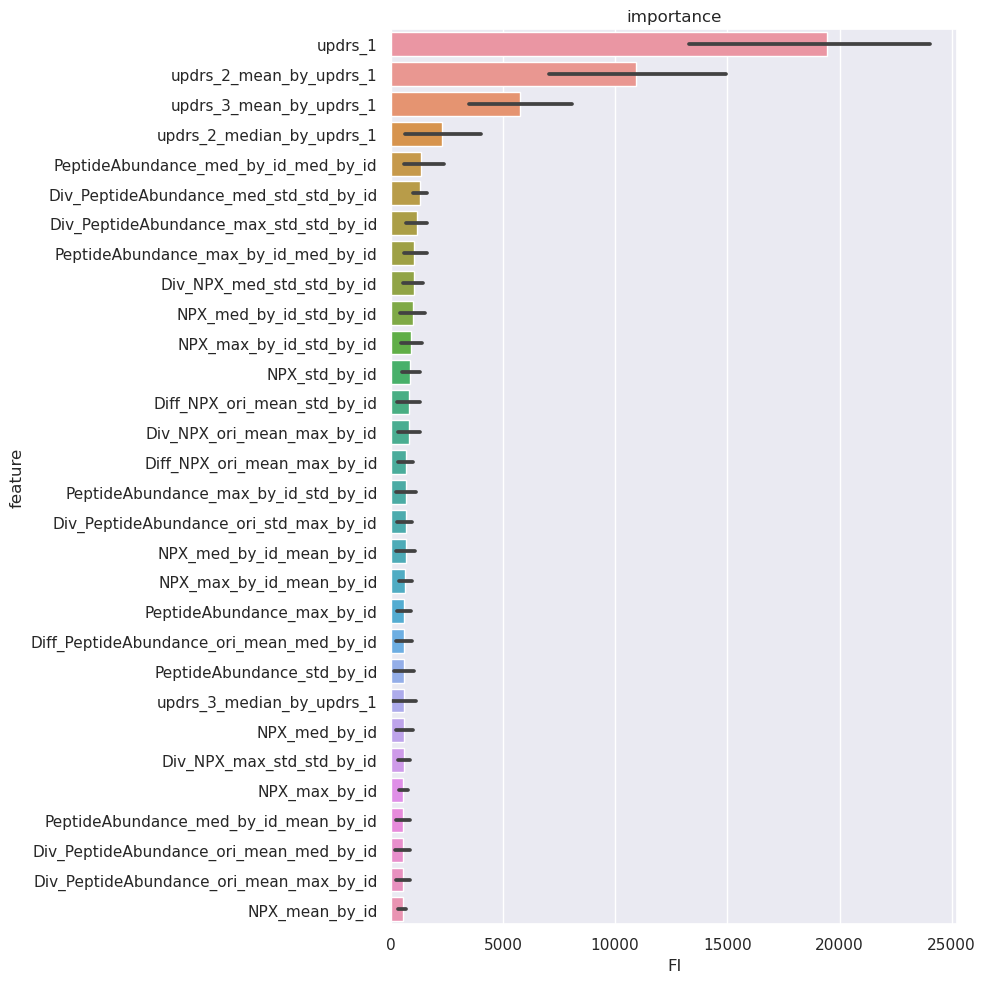

In [152]:
# feature_importances_ 上位20個の図示
TOP = 30

fi = fi_dfs[1]

order = fi.groupby('feature')['FI'].mean().sort_values(ascending=False)[:TOP].index
# 可視化
plt.figure(figsize=(10, 10))
sns.barplot(x="FI",y="feature",data=fi,order=order)
plt.title('importance')
plt.tight_layout()
plt.show()

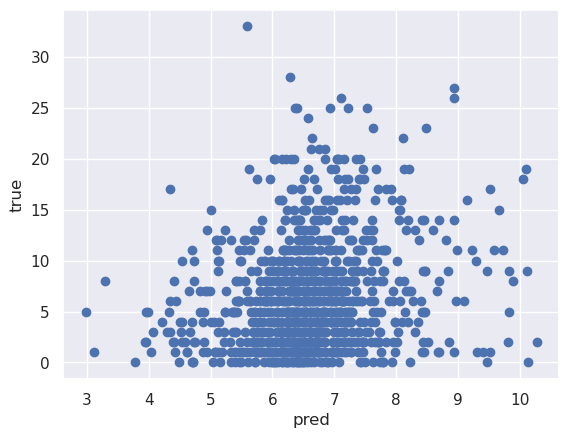

In [51]:
# 散布図の描画
plt.scatter(oof_df['oof'], oof_df['target'])
plt.xlabel('pred')
plt.ylabel('true')
plt.show()

## NN

In [43]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(X_train_NN)
X_train_NN = scaler.transform(X_train_NN)

train_X_NN, val_X_NN, train_y_NN, val_y_NN = train_test_split(X_train_NN, y_train_NN.values, test_size = config.FRAC, random_state=config.RANDOM_STATE)

train_X_NN = torch.from_numpy(train_X_NN).float()
train_y_NN = torch.from_numpy(train_y_NN).float()
val_X_NN = torch.from_numpy(val_X_NN).float()
val_y_NN = torch.from_numpy(val_y_NN).float()

#test_X = torch.from_numpy(test_X.values).float()

train_td=TensorDataset(train_X_NN, train_y_NN)
train_loader = DataLoader(train_td, batch_size=15, shuffle=True)

In [44]:
# 線形回帰ネットワークのclassをnn.Moduleの継承で定義
class Regression(nn.Module):
    # コンストラクタ(インスタンス生成時の初期化)
    def __init__(self):
        super().__init__()
        self.linear1 = nn.Linear(65, 128)
        self.linear2 = nn.Linear(128, 128)
        self.linear3 = nn.Linear(128, 128)
        self.linear4 = nn.Linear(128, 128)
        self.linear5 = nn.Linear(128, 64)
        self.linear6 = nn.Linear(64, 1)
 
    # メソッド(ネットワークをシーケンシャルに定義)
    def forward(self, x):
        x = nn.functional.relu(self.linear1(x))
        x = nn.functional.relu(self.linear2(x))
        x = nn.functional.relu(self.linear3(x))
        x = nn.functional.relu(self.linear4(x))
        x = nn.functional.relu(self.linear5(x))
        x = self.linear6(x)
        return x 
    
#model = Net()


https://watlab-blog.com/2021/06/14/pytorch-nonlinear-regression/

In [45]:
model = Regression()
#optimizer = optim.RMSprop(model.parameters(), lr=0.01) 
optimizer = optim.Adam(model.parameters(),lr=0.1,betas=(0.9,0.99),eps=1e-09)
criterion = nn.MSELoss()       
iteration = 10
losses = []

for epoch in range(iteration): 
    total_loss = 0
     
    for train_X_NN, train_y_NN in train_loader:
        train_X_NN, train_y_NN = Variable(train_X_NN), Variable(train_y_NN)
        optimizer.zero_grad()
        
        output = model(train_X_NN)
        loss = criterion(output, train_y_NN)
        
        loss.backward()
        optimizer.step()
        total_loss += loss.item() #loss.data[0]で記述するとPyTorch0.5以上ではエラーが返る
        losses.append(loss.item())    
     
    if (epoch+1) % (iteration/10) == 0:
        print(epoch+1, total_loss)
     
val_X_NN, val_y_NN = Variable(val_X_NN), Variable(val_y_NN)
y_pred = model(val_X_NN).data.numpy() 
score_cal(y_pred,val_y_NN)



/opt/conda/lib/python3.7/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([15])) that is different to the input size (torch.Size([15, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/conda/lib/python3.7/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([6])) that is different to the input size (torch.Size([6, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1 2404781.4685988426
2 9084.793420791626
3 1711.7064175605774
4 1692.208519935608
5 1675.1103219985962
6 1680.0363945960999
7 1699.687575340271
8 1677.6423768997192
9 1702.749966621399
10 1681.3537788391113


5.0770745

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
from sklearn.model_selection import GroupKFold
from torch.utils.data import DataLoader, TensorDataset

group_kfold = GroupKFold(n_splits=5)

for train, val in group_kfold.split(df, df_label, groups):
    x_train = torch.tensor(df.iloc[train].values, dtype=torch.float)
    y_train = torch.tensor(df_label.iloc[train].values, dtype=torch.float)
    x_val = torch.tensor(df.iloc[val].values, dtype=torch.float)
    y_val = torch.tensor(df_label.iloc[val].values, dtype=torch.float)

    train_dataset = TensorDataset(x_train, y_train)
    val_dataset = TensorDataset(x_val, y_val)
    train_loader = DataLoader(train_dataset, batch_size=32)
    val_loader = DataLoader(val_dataset, batch_size=32)

    model = nn.Sequential(nn.Linear(65,32), nn.ReLU(), nn.Linear(32,1))
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-3)

    for epoch in range(10):
        for x, y in train_loader:
            optimizer.zero_grad()
            y_pred = model(x)
            loss = criterion(y_pred, y)
            loss.backward()
            optimizer.step()